# End-to-end workflow for auto claims fraud detection using Amazon SageMaker

The purpose of this end-to-end example is to demonstrate how to prepare, train, and deploy a model that detects auto insurance claims.


"Auto insurance fraud ranges from misrepresenting facts on insurance applications and inflating insurance claims to staging accidents and submitting claim forms for injuries or damage that never occurred, to false reports of stolen vehicles. Fraud accounted for between 15 percent and 17 percent of total claims payments for auto insurance bodily injury in 2012, according to an Insurance Research Council (IRC) study. The study estimated that between \$5.6 billion and \$7.7 billion was fraudulently added to paid claims for auto insurance bodily injury payments in 2012, compared with a range of \$4.3 billion to \$5.8 billion in 2002. " source: Insurance Information Institute

In this example, we will use an auto insurance domain to detect claims that are possibly fraudulent.
more precisely we address the use-case: "what is the likelihood that a given auto claim is fraudulent?" , and explore the technical solution.

![](https://drive.google.com/uc?id=1es3fKkY_Om6FgTnUH_3qUxZAxBWB8UbT&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions
!pip install imbalanced-learn

# install nlp libs
!pip install transformers

In [150]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import io
import os
import sys
import time
import datetime
import string
import json
import csv
import pathlib

import awswrangler as wr

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.lineage import context, artifact, association, action
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.xgboost.estimator import XGBoost

In [53]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp11062050"
training_instance_type = "ml.m5.xlarge"

In [77]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sm
)

## Exploratory Visualizations

The dataset is synthetically generated and consists of customers and claims datasets. Here we will load them and do some exploratory visualizations.

In [ ]:
!git clone https://github.com/RecoHut-Datasets/fraud_detection
%cd fraud_detection

Cloning into 'fraud_detection'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 14 (delta 4), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (14/14), done.
/content/fraud_detection/fraud_detection


In [100]:
df_claims = pd.read_csv("claims.csv", index_col=0)
df_claims

,driver_relationship,incident_type,collision_type,incident_severity,authorities_contacted,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,total_claim_amount,incident_month,incident_day,incident_dow,incident_hour,fraud
policy_id,,,,,,,,,,,,,,,,,
1,Spouse,Collision,Front,Minor,None,2,0,0,No,71600,8913.668763,80513.668763,3,17,6,8,0
2,Self,Collision,Rear,Totaled,Police,3,4,0,Yes,6400,19746.724395,26146.724395,12,11,2,11,0
3,Self,Collision,Front,Minor,Police,2,0,1,Yes,10400,11652.969918,22052.969918,12,24,1,14,0
4,Child,Collision,Side,Minor,None,2,0,0,No,104700,11260.930936,115960.930936,12,23,0,19,0
5,Self,Collision,Side,Major,Police,2,1,0,No,3400,27987.704652,31387.704652,5,8,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,Self,Collision,Front,Minor,None,2,0,3,No,15700,1494.409549,17194.409549,8,7,2,5,1
4997,Self,Collision,Side,Minor,None,2,0,1,No,34900,14837.909976,49737.909976,1,10,3,13,0
4998,Self,Collision,Front,Minor,None,1,0,0,No,11700,12421.253027,24121.253027,6,3,0,7,0


In [101]:
df_customers = pd.read_csv("customers.csv", index_col=0)
df_customers

,customer_age,months_as_customer,num_claims_past_year,num_insurers_past_5_years,policy_state,policy_deductable,policy_annual_premium,policy_liability,customer_zip,customer_gender,customer_education,auto_year
policy_id,,,,,,,,,,,,
1,54,94,0,1,WA,750,3000,25/50,99207,Unkown,Associate,2006
2,41,165,0,1,CA,750,2950,15/30,95632,Male,Bachelor,2012
3,57,155,0,1,CA,750,3000,15/30,93203,Female,Bachelor,2017
4,39,80,0,1,AZ,750,3000,30/60,85208,Female,Advanced Degree,2020
5,39,60,0,1,CA,750,3000,15/30,91792,Female,High School,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
4996,33,4,0,3,CA,750,2550,25/50,92028,Male,Associate,2015
4997,45,150,0,1,NV,750,3000,30/60,89178,Female,Bachelor,2015
4998,28,87,0,1,CA,750,2950,25/50,91702,Male,High School,2016


In [102]:
df_combined = df_customers.join(df_claims)
df_combined

,customer_age,months_as_customer,num_claims_past_year,num_insurers_past_5_years,policy_state,policy_deductable,policy_annual_premium,policy_liability,customer_zip,customer_gender,...,num_witnesses,police_report_available,injury_claim,vehicle_claim,total_claim_amount,incident_month,incident_day,incident_dow,incident_hour,fraud
policy_id,,,,,,,,,,,,,,,,,,,,,
1,54,94,0,1,WA,750,3000,25/50,99207,Unkown,...,0,No,71600,8913.668763,80513.668763,3,17,6,8,0
2,41,165,0,1,CA,750,2950,15/30,95632,Male,...,0,Yes,6400,19746.724395,26146.724395,12,11,2,11,0
3,57,155,0,1,CA,750,3000,15/30,93203,Female,...,1,Yes,10400,11652.969918,22052.969918,12,24,1,14,0
4,39,80,0,1,AZ,750,3000,30/60,85208,Female,...,0,No,104700,11260.930936,115960.930936,12,23,0,19,0
5,39,60,0,1,CA,750,3000,15/30,91792,Female,...,0,No,3400,27987.704652,31387.704652,5,8,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,33,4,0,3,CA,750,2550,25/50,92028,Male,...,3,No,15700,1494.409549,17194.409549,8,7,2,5,1
4997,45,150,0,1,NV,750,3000,30/60,89178,Female,...,1,No,34900,14837.909976,49737.909976,1,10,3,13,0
4998,28,87,0,1,CA,750,2950,25/50,91702,Male,...,0,No,11700,12421.253027,24121.253027,6,3,0,7,0


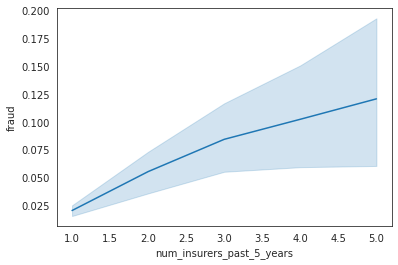

In [103]:
sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_combined);

Fraud is positively correlated with having a greater number of insurers over the past 5 years. Customers who switched insurers more frequently also had more prevelance of fraud.

In [104]:
combined_stats = []

for col in df_combined.columns:
    combined_stats.append(
        (
            col,
            df_combined[col].nunique(),
            df_combined[col].isnull().sum() * 100 / df_combined.shape[0],
            df_combined[col].value_counts(normalize=True, dropna=False).values[0] * 100,
            df_combined[col].dtype,
        )
    )

stats_df = pd.DataFrame(
    combined_stats,
    columns=["feature", "unique_values", "percent_missing", "percent_largest_category", "datatype"],
)
stats_df.sort_values("percent_largest_category", ascending=False)
stats_df

,feature,unique_values,percent_missing,percent_largest_category,datatype
0,customer_age,53,0.00,3.14,int64
1,months_as_customer,346,0.00,0.90,int64
2,num_claims_past_year,7,0.00,93.30,int64
3,num_insurers_past_5_years,5,0.00,77.20,int64
4,policy_state,6,0.00,62.68,object
5,policy_deductable,8,0.00,99.00,int64
6,policy_annual_premium,17,0.00,71.60,int64
7,policy_liability,4,0.00,33.94,object
8,customer_zip,1743,0.00,0.30,int64
9,customer_gender,4,0.00,45.62,object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


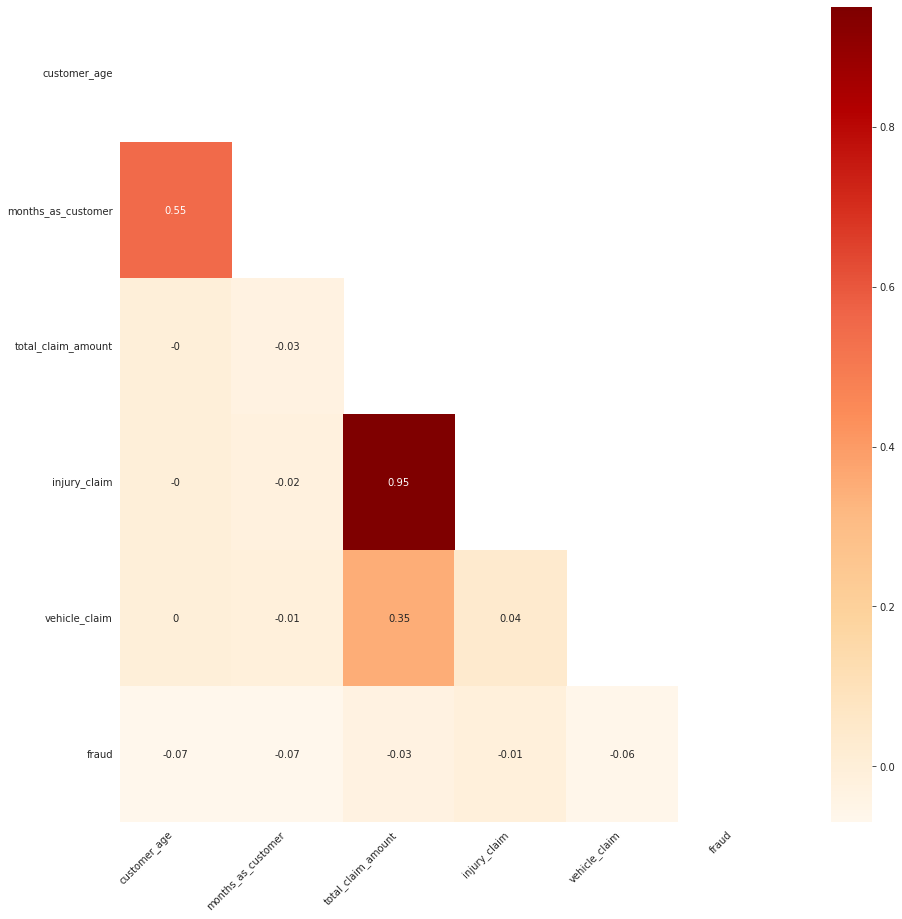

In [105]:
sns.set_style("white")

corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity",
    "fraud",
]

corr_df = df_combined[corr_list]
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(15, 15))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="OrRd")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

## Data Ingest

In [132]:
traing_job_output_path = f"s3://{bucket}/{prefix}/training_jobs"
bias_report_1_output_path = f"s3://{bucket}/{prefix}/clarify-bias-1"
bias_report_2_output_path = f"s3://{bucket}/{prefix}/clarify-bias-2"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-explainability"

train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

predictor_instance_count = 1
predictor_instance_type = "ml.c5.xlarge"

estimator_output_path = f"s3://{bucket}/{prefix}/training_jobs"
xgb_model_name = "xgb-insurance-claims-fraud-model"

batch_transform_instance_count = 1
batch_transform_instance_type = "ml.c5.xlarge"

model_2_name = f"{prefix}-xgboost-post-smote"

train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"

In [ ]:
# Before you can preprocess the raw data with Data Wrangler, it must exist in S3
s3.upload_file(
    Filename="claims.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims.csv"
)
s3.upload_file(
    Filename="customers.csv", Bucket=bucket, Key=f"{prefix}/data/raw/customers.csv"
)

In [74]:
# Update attributes within the .flow file

!wget -q --show-progress https://raw.githubusercontent.com/RecoHut-Datasets/fraud_detection/main/claims_flow_template
!wget -q --show-progress https://raw.githubusercontent.com/RecoHut-Datasets/fraud_detection/main/customers_flow_template

claims_flow_template_file = "claims_flow_template"

with open(claims_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    claims_flow = template.substitute(variables)
    claims_flow = json.loads(claims_flow)

with open("claims.flow", "w") as f:
    json.dump(claims_flow, f)

customers_flow_template_file = "customers_flow_template"

with open(customers_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    customers_flow = template.substitute(variables)
    customers_flow = json.loads(customers_flow)

with open("customers.flow", "w") as f:
    json.dump(customers_flow, f)

claims_flow_templat 100%[===================>]  44.09K  --.-KB/s    in 0.01s   
customers_flow_temp 100%[===================>]  22.05K  --.-KB/s    in 0.001s  


## Data Prepare

**Load preprocessed data from Data Wrangler job**

If you ran the Data Wrangler jobs from claims.flow and customers.flow, you can load your preprocessed data here. If you did not run the Data Wrangler job, you can still get started by loading the pre-made data sets from the /data directory of this example.

In [97]:
claims_dtypes = {
    "policy_id": int,
    "incident_severity": int,
    "num_vehicles_involved": int,
    "num_injuries": int,
    "num_witnesses": int,
    "police_report_available": int,
    "injury_claim": float,
    "vehicle_claim": float,
    "total_claim_amount": float,
    "incident_month": int,
    "incident_day": int,
    "incident_dow": int,
    "incident_hour": int,
    "fraud": int,
    "driver_relationship_self": int,
    "driver_relationship_na": int,
    "driver_relationship_spouse": int,
    "driver_relationship_child": int,
    "driver_relationship_other": int,
    "incident_type_collision": int,
    "incident_type_breakin": int,
    "incident_type_theft": int,
    "collision_type_front": int,
    "collision_type_rear": int,
    "collision_type_side": int,
    "collision_type_na": int,
    "authorities_contacted_police": int,
    "authorities_contacted_none": int,
    "authorities_contacted_fire": int,
    "authorities_contacted_ambulance": int,
    "event_time": float,
}

customers_dtypes = {
    "policy_id": int,
    "customer_age": int,
    "customer_education": int,
    "months_as_customer": int,
    "policy_deductable": int,
    "policy_annual_premium": int,
    "policy_liability": int,
    "auto_year": int,
    "num_claims_past_year": int,
    "num_insurers_past_5_years": int,
    "customer_gender_male": int,
    "customer_gender_female": int,
    "policy_state_ca": int,
    "policy_state_wa": int,
    "policy_state_az": int,
    "policy_state_or": int,
    "policy_state_nv": int,
    "policy_state_id": int,
    "event_time": float,
}

In [107]:
# This is your DataFlow output path if you decide to redo the work in DataFlow on your own
flow_output_path = ""

claims_flow_path = ""
customers_flow_path = ""

try:
    # this will try to load the exported dataframes from the claims and customers .flow files
    claims_s3_path = f"{flow_output_path}/claims_output"
    customers_s3_path = f"{flow_output_path}/customers_output"

    claims_preprocessed = wr.s3.read_csv(path=claims_s3_path, dataset=True, dtype=claims_dtypes)

    customers_preprocessed = wr.s3.read_csv(
        path=customers_s3_path, dataset=True, dtype=customers_dtypes
    )

except:
    # if the Data Wrangler job was not run, the claims and customers dataframes will be loaded from local copies
    timestamp = pd.to_datetime("now").timestamp()
    print("Unable to load Data Wrangler output. Loading pre-made dataframes...")

    claims_preprocessed = pd.read_csv(
        filepath_or_buffer="claims_preprocessed.csv", dtype=claims_dtypes
    )

    # a timestamp column is required by the feature store, so one is added with a current timestamp
    claims_preprocessed["event_time"] = timestamp

    customers_preprocessed = pd.read_csv(
        filepath_or_buffer="customers_preprocessed.csv", dtype=customers_dtypes
    )

    customers_preprocessed["event_time"] = timestamp

    print("Complete")

Unable to load Data Wrangler output. Loading pre-made dataframes...
Complete


In [111]:
claims_preprocessed.columns

Index(['policy_id', 'incident_severity', 'num_vehicles_involved',
       'num_injuries', 'num_witnesses', 'police_report_available',
       'injury_claim', 'vehicle_claim', 'total_claim_amount', 'incident_month',
       'incident_day', 'incident_dow', 'incident_hour', 'fraud',
       'driver_relationship_self', 'driver_relationship_na',
       'driver_relationship_spouse', 'driver_relationship_child',
       'driver_relationship_other', 'incident_type_collision',
       'incident_type_breakin', 'incident_type_theft', 'collision_type_front',
       'collision_type_rear', 'collision_type_side', 'collision_type_na',
       'authorities_contacted_police', 'authorities_contacted_none',
       'authorities_contacted_fire', 'authorities_contacted_ambulance',
       'event_time'],
      dtype='object')

## Load data into feature store

In [112]:
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sm,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

# configure the feature group

claims_fg_name = f"{prefix}-claims"
customers_fg_name = f"{prefix}-customers"

claims_feature_group = FeatureGroup(name=claims_fg_name, sagemaker_session=feature_store_session)
customers_feature_group = FeatureGroup(
    name=customers_fg_name, sagemaker_session=feature_store_session
)

claims_feature_group.load_feature_definitions(data_frame=claims_preprocessed)
customers_feature_group.load_feature_definitions(data_frame=customers_preprocessed);

# create the feature group
'''You must tell the Feature Group which columns in the dataframe correspond 
to the required record indentifier and event time features.'''
print(f"{customers_fg_name} -- {claims_fg_name} are the feature group names in use")

record_identifier_feature_name = "policy_id"
event_time_feature_name = "event_time"

try:
    print(f"\n Using s3://{bucket}/{prefix}")
    claims_feature_group.create(
        s3_uri=f"s3://{bucket}/{prefix}",
        record_identifier_name=record_identifier_feature_name,
        event_time_feature_name=event_time_feature_name,
        role_arn=role_arn,
        enable_online_store=True,
    )
    print(f'Create "claims" feature group: SUCCESS')

except Exception as e:
    code = e.response.get("Error").get("Code")
    if code == "ResourceInUse":
        print(f"Using existing feature group: {claims_fg_name}")
    else:
        raise (e)

try:
    customers_feature_group.create(
        s3_uri=f"s3://{bucket}/{prefix}",
        record_identifier_name=record_identifier_feature_name,
        event_time_feature_name=event_time_feature_name,
        role_arn=role_arn,
        enable_online_store=True,
    )
    print(f'Create "customers" feature group: SUCCESS')

except Exception as e:
    code = e.response.get("Error").get("Code")
    if code == "ResourceInUse":
        print(f"Using existing feature group: {customers_fg_name}")
    else:
        raise (e)

# Wait until feature group creation has fully completed

def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


wait_for_feature_group_creation_complete(feature_group=claims_feature_group)
wait_for_feature_group_creation_complete(feature_group=customers_feature_group)

# Ingest records into the Feature Groups
'''After the Feature Groups have been created, we can put data into each 
store by using the PutRecord API. This API can handle high TPS and is 
designed to be called by different streams. The data from all of these 
Put requests is buffered and written to s3 in chunks. The files will be 
written to the offline store within a few minutes of ingestion.'''

claims_feature_group.ingest(data_frame=claims_preprocessed, max_workers=3, wait=True)
customers_feature_group.ingest(data_frame=customers_preprocessed, max_workers=3, wait=True);

# Wait for offline store data to become available
'''This usually takes 5-8 minutes'''

claims_table = claims_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"]
customers_table = customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"]

claims_feature_group_s3_prefix = (
    f"{prefix}/{account_id}/sagemaker/{region}/offline-store/{claims_table}/data"
)
customers_feature_group_s3_prefix = (
    f"{prefix}/{account_id}/sagemaker/{region}/offline-store/{customers_table}/data"
)

print(claims_feature_group_s3_prefix)

offline_store_contents = None

while offline_store_contents is None:
    objects_in_bucket = s3.list_objects(
        Bucket=bucket, Prefix=customers_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...")
        time.sleep(60)

print("\nData available.")

claims_feature_group.describe()["OfflineStoreConfig"][
    "DataCatalogConfig"
], customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]

sagemaker-exp11062050-customers -- sagemaker-exp11062050-claims are the feature group names in use

 Using s3://sagemaker-us-east-1-390354360073/sagemaker-exp11062050
Create "claims" feature group: SUCCESS
Create "customers" feature group: SUCCESS
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup sagemaker-exp11062050-claims successfully created.
FeatureGroup sagemaker-exp11062050-customers successfully created.
sagemaker-exp11062050/390354360073/sagemaker/us-east-1/offline-store/sagemaker-exp11062050-claims-1654971118/data
Waiting for data in offline store...
Waiting for data in offline store...
Waiting for data in offline store...
Waiting for data in offline store...
Waiting for data in offline store...

Data available.


({'Catalog': 'AwsDataCatalog',
  'Database': 'sagemaker_featurestore',
  'TableName': 'sagemaker-exp11062050-claims-1654971118'},
 {'Catalog': 'AwsDataCatalog',
  'Database': 'sagemaker_featurestore',
  'TableName': 'sagemaker-exp11062050-customers-1654971120'})

## Create Train and Test Datasets

Once the data is available in the offline store, it will automatically be cataloged and loaded into an Athena table (this is done by default, but can be turned off). In order to build our training and test datasets, you will submit a SQL query to join the the Claims and Customers tables created in Athena.

In [113]:
claims_query = claims_feature_group.athena_query()
customers_query = customers_feature_group.athena_query()

claims_table = claims_query.table_name
customers_table = customers_query.table_name
database_name = customers_query.database

feature_columns = list(set(claims_preprocessed.columns) ^ set(customers_preprocessed.columns))
feature_columns_string = ", ".join(f'"{c}"' for c in feature_columns)
feature_columns_string = f'"{claims_table}".policy_id as policy_id, ' + feature_columns_string

query_string = f"""
SELECT DISTINCT {feature_columns_string}
FROM "{claims_table}" LEFT JOIN "{customers_table}" 
ON "{claims_table}".policy_id = "{customers_table}".policy_id
"""

claims_query.run(query_string=query_string, output_location=f"s3://{bucket}/{prefix}/query_results")
claims_query.wait()
dataset = claims_query.as_dataframe()
dataset.to_csv("./claims_customer.csv")

col_order = ["fraud"] + list(dataset.drop(["fraud", "policy_id"], axis=1).columns)

train = dataset.sample(frac=0.80, random_state=0)[col_order]
test = dataset.drop(train.index)[col_order]

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
dataset.to_csv("dataset.csv", index=True)

In [114]:
train.head(5)

,fraud,policy_state_nv,auto_year,num_injuries,policy_state_wa,driver_relationship_child,collision_type_na,authorities_contacted_ambulance,incident_hour,collision_type_front,...,incident_day,collision_type_rear,num_witnesses,incident_dow,months_as_customer,police_report_available,vehicle_claim,policy_state_ca,driver_relationship_spouse,collision_type_side
398,0,0,2018,0,1,0,0,0,3,1,...,10,0,3,6,159,1,11000.0,0,0,0
3833,0,0,2017,0,0,0,0,0,14,0,...,25,1,1,4,102,0,8000.0,1,0,0
4836,0,0,2016,0,0,0,0,0,14,1,...,3,0,0,1,212,0,10500.0,1,0,0
4572,0,0,2019,0,1,0,1,0,9,0,...,27,0,0,2,139,0,23000.0,0,0,0
636,0,0,2020,0,0,1,0,0,4,1,...,1,0,0,2,16,0,17500.0,1,0,0


In [115]:
test.head(5)

,fraud,policy_state_nv,auto_year,num_injuries,policy_state_wa,driver_relationship_child,collision_type_na,authorities_contacted_ambulance,incident_hour,collision_type_front,...,incident_day,collision_type_rear,num_witnesses,incident_dow,months_as_customer,police_report_available,vehicle_claim,policy_state_ca,driver_relationship_spouse,collision_type_side
0,0,0,2020,4,0,0,0,0,14,0,...,15,1,0,1,95,1,44000.0,1,1,0
7,0,0,2017,1,0,0,0,0,6,1,...,19,0,0,0,221,1,35000.0,1,0,0
21,0,0,2017,0,0,0,0,0,8,0,...,18,1,1,3,108,1,25000.0,0,0,0
24,0,1,2012,0,0,0,0,0,8,0,...,3,1,0,0,60,0,11000.0,0,0,0
25,0,0,2014,0,0,0,0,0,6,0,...,23,0,3,5,11,1,13500.0,1,0,1


In [118]:
train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"

s3.upload_file(
    Filename="train.csv", Bucket=bucket, Key=f"{prefix}/data/train/train.csv"
)
s3.upload_file(Filename="test.csv", Bucket=bucket, Key=f"{prefix}/data/test/test.csv")

## Train a Model using XGBoost

In [120]:
%%writefile xgboost_starter_script.py
import argparse
import json
import os
import pickle
import sys

import pandas as pd
import xgboost as xgb

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here
    parser.add_argument("--num_round", type=int, default=999)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--nfold", type=int, default=5)
    parser.add_argument("--early_stopping_rounds", type=int, default=10)
    parser.add_argument("--train_data_path", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))

    # SageMaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--output-data-dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

    args = parser.parse_args()

    data = pd.read_csv(f"{args.train_data_path}/train.csv")
    train = data.drop("fraud", axis=1)
    label = pd.DataFrame(data["fraud"])
    dtrain = xgb.DMatrix(train, label=label)

    params = {"max_depth": args.max_depth, "eta": args.eta, "objective": args.objective}
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds

    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=("auc"),
        seed=0,
    )

    print(f"[0]#011train-auc:{cv_results.iloc[-1]['train-auc-mean']}")
    #print(f"[1]#011train-auc std:{cv_results.iloc[-1]['train-auc-std']}")
    print(f"[1]#011validation-auc:{cv_results.iloc[-1]['test-auc-mean']}")
    #print(f"[1]#011validation-auc std:{cv_results.iloc[-1]['test-auc-std']}")

    metrics_data = {
        "binary_classification_metrics": {
            "validation:auc": {
                "value": cv_results.iloc[-1]["test-auc-mean"],
                "standard_deviation": cv_results.iloc[-1]["test-auc-std"]
            },
            "train:auc": {
                "value": cv_results.iloc[-1]["train-auc-mean"],
                "standard_deviation": cv_results.iloc[-1]["train-auc-std"]
            },
        }
    }
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))

    # Save the model to the location specified by ``model_dir``
    metrics_location = args.output_data_dir + "/metrics.json"
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        pickle.dump(model, f)

Writing xgboost_starter_script.py


In [121]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}

xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    output_path=estimator_output_path,
    code_location=estimator_output_path,
    hyperparameters=hyperparameters,
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

xgb_estimator.fit(inputs={"train": train_data_uri})
training_job_1_name = xgb_estimator.latest_training_job.job_name

2022-06-11 19:10:05 Starting - Starting the training job...
2022-06-11 19:10:33 Starting - Preparing the instances for trainingProfilerReport-1654974605: InProgress
............
2022-06-11 19:12:29 Downloading - Downloading input data...
2022-06-11 19:12:49 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for xgboost-starter-script: filename=xgboost_starter_script-1.0.0-py2.py3-none-any.whl size=5009 sha256=ea6369db

## Model Lineage with Artifacts and Associations

In [122]:
training_job_1_info = sm.describe_training_job(
    TrainingJobName=training_job_1_name
)

code_s3_uri = training_job_1_info["HyperParameters"]["sagemaker_submit_directory"]

matching_artifacts = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=code_s3_uri, sagemaker_session=sagemaker_session
    )
)

# use existing arifact if it's already been created, otherwise create a new artifact
if matching_artifacts:
    code_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingScript",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

training_data_s3_uri = training_job_1_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

matching_artifacts = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session
    )
)

if matching_artifacts:
    training_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

trained_model_s3_uri = training_job_1_info["ModelArtifacts"]["S3ModelArtifacts"]

matching_artifacts = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session
    )
)

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

trial_component = sm.describe_trial_component(
    TrialComponentName=training_job_1_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sagemaker_session,
        )
        print(f"Association with {a.artifact_type}: SUCCEESFUL")
    except:
        print(f"Association already exists with {a.artifact_type}")

output_artifacts = [model_artifact]

for a in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sagemaker_session,
        )
        print(f"Association with {a.artifact_type}: SUCCESSFUL")
    except:
        print(f"Association already exists with {a.artifact_type}")

Create artifact arn:aws:sagemaker:us-east-1:390354360073:artifact/b602045a3d02f107f6e05789658fbd5c: SUCCESSFUL
Using existing artifact: arn:aws:sagemaker:us-east-1:390354360073:artifact/ba892d37f90f358f6fe26025254b6f9e
Using existing artifact: arn:aws:sagemaker:us-east-1:390354360073:artifact/584102923e4aca52d976b3243daa7f43
Association with Code: SUCCEESFUL
Association already exists with DataSet
Association with Model: SUCCESSFUL


## Evaluate Model for Bias with Clarify

In [123]:
# Create model from estimator

model_1_name = f"{prefix}-xgboost-pre-smote"
model_matches = sm.list_models(NameContains=model_1_name)["Models"]

if not model_matches:

    model_1 = sagemaker_session.create_model_from_job(
        name=model_1_name,
        training_job_name=training_job_1_info["TrainingJobName"],
        role=role,
        image_uri=training_job_1_info["AlgorithmSpecification"]["TrainingImage"],
    )
else:

    print(f"Model {model_1_name} already exists.")

In [ ]:
# Check for data set bias and model bias
'''With SageMaker, we can check for pre-training and post-training bias. 
Pre-training metrics show pre-existing bias in that data, while post-training 
metrics show bias in the predictions from the model. Using the SageMaker SDK, 
we can specify which groups we want to check bias across and which metrics 
we'd like to show.'''

train_cols = wr.s3.read_csv(training_data_s3_uri).columns.to_list()

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=bias_report_1_output_path,
    label="fraud",
    headers=train_cols,
    dataset_type="text/csv",
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_1_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

# un-comment the code below to run the whole job

# if 'clarify_bias_job_1_name' not in locals():

#     clarify_processor.run_bias(
#         data_config=bias_data_config,
#         bias_config=bias_config,
#         model_config=model_config,
#         model_predicted_label_config=predictions_config,
#         pre_training_methods='all',
#         post_training_methods='all')

#     clarify_bias_job_1_name = clarify_processor.latest_job.name
#     %store clarify_bias_job_1_name

# else:
#     print(f'Clarify job {clarify_bias_job_name} has already run successfully.')

In [129]:
'''
Running Clarify on your dataset or model can take ~15 minutes. If you don't 
have time to run the job, you can view the pre-generated results included 
with this demo. Otherwise, you can run the job by un-commenting the code 
in the cell above.
'''

if "clarify_bias_job_1_name" in locals():
    s3.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/bias_1/analysis.json",
        Filename="clarify_output/bias_1/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_bias_job_1_name}")
else:
    print(f"Loading pre-generated analysis file...")

with open("clarify_output/bias_1/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]

print(json.dumps(results, indent=4))

Loading pre-generated analysis file...
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.398
}


## Deposit Model and Lineage in SageMaker Model Registry

Once a useful model has been trained and its artifacts properly associated, the next step is to save the model in a registry for future reference and possible deployment.

In [130]:
class InferenceSpecification:

    template = """
{    
    "InferenceSpecification": {
        "Containers" : [{"Image": "IMAGE_REPLACE_ME"}],
        "SupportedTransformInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedRealtimeInferenceInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedContentTypes": CONTENT_TYPES_REPLACE_ME,
        "SupportedResponseMIMETypes": RESPONSE_MIME_TYPES_REPLACE_ME
    }
}
"""

    def get_inference_specification_dict(
        self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None
    ):
        return json.loads(
            self.get_inference_specification_json(
                ecr_image, supports_gpu, supported_content_types, supported_mime_types
            )
        )

    def get_inference_specification_json(
        self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None
    ):
        if supported_mime_types is None:
            supported_mime_types = []
        if supported_content_types is None:
            supported_content_types = []
        return (
            self.template.replace("IMAGE_REPLACE_ME", ecr_image)
            .replace("INSTANCES_REPLACE_ME", self.get_supported_instances(supports_gpu))
            .replace("CONTENT_TYPES_REPLACE_ME", json.dumps(supported_content_types))
            .replace("RESPONSE_MIME_TYPES_REPLACE_ME", json.dumps(supported_mime_types))
        )

    def get_supported_instances(self, supports_gpu):
        cpu_list = [
            "ml.m4.xlarge",
            "ml.m4.2xlarge",
            "ml.m4.4xlarge",
            "ml.m4.10xlarge",
            "ml.m4.16xlarge",
            "ml.m5.large",
            "ml.m5.xlarge",
            "ml.m5.2xlarge",
            "ml.m5.4xlarge",
            "ml.m5.12xlarge",
            "ml.m5.24xlarge",
            "ml.c4.xlarge",
            "ml.c4.2xlarge",
            "ml.c4.4xlarge",
            "ml.c4.8xlarge",
            "ml.c5.xlarge",
            "ml.c5.2xlarge",
            "ml.c5.4xlarge",
            "ml.c5.9xlarge",
            "ml.c5.18xlarge",
        ]
        gpu_list = [
            "ml.p2.xlarge",
            "ml.p2.8xlarge",
            "ml.p2.16xlarge",
            "ml.p3.2xlarge",
            "ml.p3.8xlarge",
            "ml.p3.16xlarge",
        ]

        list_to_return = cpu_list

        if supports_gpu:
            list_to_return = cpu_list + gpu_list

        return json.dumps(list_to_return)

In [131]:
# Create Model Package Group
'''A Model Package Groups holds multiple versions or iterations of a model. 
Though it is not required to create them for every model in the registry, 
they help organize various models which all have the same purpose and provide 
automatic versioning.'''

mpg_name = prefix
print(f"Model Package Group name: {mpg_name}")
mpg_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageGroupDescription": "Insurance claim fraud detection",
}
matching_mpg = sm.list_model_package_groups(NameContains=mpg_name)['ModelPackageGroupSummaryList']

if matching_mpg:
    print(f'Using existing Model Package Group: {mpg_name}')
else:
    mpg_response = sm.create_model_package_group(**mpg_input_dict)
    print(f'Create Model Package Group {mpg_name}: SUCCESSFUL')

# Create and upload a metrics report

model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_1_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = (
    f"{prefix}/training_jobs/{training_job_1_info['TrainingJobName']}/training_metrics.json"
)
s3.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

# Define the inference spec

mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_1_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_1_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

# Define model metrics

model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{bias_report_1_output_path}/analysis.json",
        }
    },
}

mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect insurance fraud.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp1_response = sm.create_model_package(**mp_input_dict)

# Wait until model package is completed

mp_info = sm.describe_model_package(
    ModelPackageName=mp1_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sm.describe_model_package(
        ModelPackageName=mp1_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

# View model package in registry

sm.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

Model Package Group name: sagemaker-exp11062050
Create Model Package Group sagemaker-exp11062050: SUCCESSFUL
model package status: Completed


[{'CreationTime': datetime.datetime(2022, 6, 11, 19, 45, 14, 789000, tzinfo=tzlocal()),
  'ModelApprovalStatus': 'PendingManualApproval',
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:390354360073:model-package/sagemaker-exp11062050/1',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud.',
  'ModelPackageGroupName': 'sagemaker-exp11062050',
  'ModelPackageStatus': 'Completed',
  'ModelPackageVersion': 1}]

## Create an End to End Pipeline

Now that youve manually done each step in our machine learning workflow, you can certain steps to allow for faster model experimentation without sacrificing transparncy and model tracking. In this section you will create a pipeline which trains a new model, persists the model in SageMaker and then adds the model to the registry. We will build a SageMaker Pipeline that automates the entire end-to-end process of preparing, training, and deploying a model that detects automobile claim fraud.

![](https://drive.google.com/uc?id=1etK0JUMYGse3-z3G8SU7UfWZilDGGuR2&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [133]:
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString

In [134]:
training_job_output_path = f"s3://{bucket}/{prefix}/training_jobs"
bias_report_output_path = f"s3://{bucket}/{prefix}/clarify-bias"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-explainability"

train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"
train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"
processing_dir = "/opt/ml/processing"
create_dataset_script_uri = f"s3://{bucket}/{prefix}/code/create_dataset.py"
pipeline_bias_output_path = f"s3://{bucket}/{prefix}/clarify-output/pipeline/bias"
deploy_model_script_uri = f"s3://{bucket}/{prefix}/code/deploy_model.py"

flow_instance_count = 1
flow_instance_type = "ml.m5.4xlarge"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

deploy_model_instance_type = "ml.m4.xlarge"

In [135]:
train_instance_param = ParameterString(
    name="TrainingInstance",
    default_value="ml.m4.xlarge",
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

### Upload raw data to S3

In [136]:
s3.upload_file(
    Filename="claims.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims.csv"
)
s3.upload_file(
    Filename="customers.csv", Bucket=bucket, Key=f"{prefix}/data/raw/customers.csv"
)

### Upload flow to S3

This will become an input to the first step and, as such, needs to be in S3.

In [137]:
claims_flow_template_file = "claims_flow_template"

with open(claims_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    claims_flow = template.substitute(variables)
    claims_flow = json.loads(claims_flow)

with open("claims.flow", "w") as f:
    json.dump(claims_flow, f)

customers_flow_template_file = "customers_flow_template"

with open(customers_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    customers_flow = template.substitute(variables)
    customers_flow = json.loads(customers_flow)

with open("customers.flow", "w") as f:
    json.dump(customers_flow, f)

In [138]:
s3.upload_file(
    Filename="claims.flow", Bucket=bucket, Key=f"{prefix}/dataprep-notebooks/claims.flow"
)
claims_flow_uri = f"s3://{bucket}/{prefix}/dataprep-notebooks/claims.flow"
print(f"Claims flow file uploaded to S3")

Claims flow file uploaded to S3


### Define the first Data Wrangler step's inputs

In [139]:
with open("claims.flow", "r") as f:
    claims_flow = json.load(f)

flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri, destination=f"{processing_dir}/flow", input_name="flow"
)

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in claims_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"],
            destination=f"{processing_dir}/{name}",
            input_name=name,
        )
        flow_step_inputs.append(s3_input)

### Define outputs for first Data Wranger step

In [140]:
claims_output_name = (
    f"{claims_flow['nodes'][-1]['node_id']}.{claims_flow['nodes'][-1]['outputs'][0]['name']}"
)

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=claims_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(feature_group_name=claims_fg_name),
    app_managed=True,
)

flow_step_outputs.append(flow_output)

### Define processor and processing step

In [141]:
image_uri = retrieve(framework="data-wrangler", region=region)

print("image_uri: {}".format(image_uri))

flow_processor = sagemaker.processing.Processor(
    role=role,
    image_uri=image_uri,
    instance_count=flow_instance_count,
    instance_type=flow_instance_type,
    max_runtime_in_seconds=86400,
)

output_content_type = "CSV"

# Output configuration used as processing job container arguments
claims_output_config = {claims_output_name: {"content_type": output_content_type}}

claims_flow_step = ProcessingStep(
    name="ClaimsDataWranglerProcessingStep",
    processor=flow_processor,
    inputs=flow_step_inputs,
    outputs=flow_step_outputs,
    job_arguments=[f"--output-config '{json.dumps(claims_output_config)}'"],
)

image_uri: 663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:1.x


### Customers Data Wrangler Preprocessing Step

In [142]:
s3.upload_file(
    Filename="customers.flow", Bucket=bucket, Key=f"{prefix}/dataprep-notebooks/customers.flow"
)
claims_flow_uri = f"s3://{bucket}/{prefix}/dataprep-notebooks/customers.flow"
print(f"Customers flow file uploaded to S3")

with open("customers.flow", "r") as f:
    customers_flow = json.load(f)

flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri, destination=f"{processing_dir}/flow", input_name="flow"
)

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in customers_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"],
            destination=f"{processing_dir}/{name}",
            input_name=name,
        )
        flow_step_inputs.append(s3_input)

customers_output_name = (
    f"{customers_flow['nodes'][-1]['node_id']}.{customers_flow['nodes'][-1]['outputs'][0]['name']}"
)

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=customers_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(
        feature_group_name=customers_fg_name
    ),
    app_managed=True,
)

flow_step_outputs.append(flow_output)

output_content_type = "CSV"

# Output configuration used as processing job container arguments
customers_output_config = {customers_output_name: {"content_type": output_content_type}}

customers_flow_step = ProcessingStep(
    name="CustomersDataWranglerProcessingStep",
    processor=flow_processor,
    inputs=flow_step_inputs,
    outputs=flow_step_outputs,
    job_arguments=[f"--output-config '{json.dumps(customers_output_config)}'"],
)

Customers flow file uploaded to S3


### Create Dataset and Train/Test Split

In [143]:
%%writefile create_dataset.py
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "sagemaker"])

import argparse
import pathlib
import time

import boto3
import pandas as pd
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup

# Parse argument variables passed via the CreateDataset processing step
parser = argparse.ArgumentParser()
parser.add_argument("--claims-feature-group-name", type=str)
parser.add_argument("--customers-feature-group-name", type=str)
parser.add_argument("--athena-database-name", type=str)
parser.add_argument("--claims-table-name", type=str)
parser.add_argument("--customers-table-name", type=str)
parser.add_argument("--bucket-name", type=str)
parser.add_argument("--bucket-prefix", type=str)
parser.add_argument("--region", type=str, default="us-east-2")
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
s3_client = boto3.client("s3")
account_id = boto3.client("sts").get_caller_identity()["Account"]
now = pd.to_datetime("now")

feature_store_session = sagemaker.Session()
claims_feature_group = FeatureGroup(name=args.claims_feature_group_name, sagemaker_session=feature_store_session)
customers_feature_group = FeatureGroup(
    name=args.customers_feature_group_name, sagemaker_session=feature_store_session
)

claims_table_name = (
    claims_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"]
)
customers_table_name = (
    customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]["TableName"]
)
athena_database_name = customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]["Database"]

print(f'claims_table_name: {claims_table_name}')
print(f'customers_table_name: {customers_table_name}')

claims_feature_group_s3_prefix = f'{args.bucket_prefix}/{account_id}/sagemaker/{region}/offline-store/{claims_table_name}/data/year={now.year}/month={now.strftime("%m")}/day={now.strftime("%d")}'
customers_feature_group_s3_prefix = f'{args.bucket_prefix}/{account_id}/sagemaker/{region}/offline-store/{customers_table_name}/data/year={now.year}/month={now.strftime("%m")}/day={now.strftime("%d")}'

print(f'claims_feature_group_s3_prefix: {claims_feature_group_s3_prefix}')
print(f'customers_feature_group_s3_prefix: {customers_feature_group_s3_prefix}')

# wait for data to be added to offline feature store
offline_store_contents = None
while offline_store_contents is None:
    claims_objects = s3_client.list_objects(
        Bucket=args.bucket_name, Prefix=claims_feature_group_s3_prefix
    )
    customers_objects = s3_client.list_objects(
        Bucket=args.bucket_name, Prefix=customers_feature_group_s3_prefix
    )
    # objects_in_bucket = s3_client.list_objects(Bucket=args.bucket_name, Prefix=customers_feature_group_s3_prefix)
    if "Contents" in claims_objects and "Contents" in customers_objects:
        num_datasets = len(claims_objects["Contents"]) + len(customers_objects["Contents"])
    else:
        num_datasets = 0

    if num_datasets >= 2:
        offline_store_contents = customers_objects["Contents"]
    else:
        print(
            f"Waiting for data in offline store: {args.bucket_name}/{customers_feature_group_s3_prefix}"
        )
        time.sleep(60)

print("Data available.")

# query athena table
athena = boto3.client("athena", region_name=region)

training_columns = [
    "fraud",
    "incident_severity",
    "num_vehicles_involved",
    "num_injuries",
    "num_witnesses",
    "police_report_available",
    "injury_claim",
    "vehicle_claim",
    "total_claim_amount",
    "incident_month",
    "incident_day",
    "incident_dow",
    "incident_hour",
    "driver_relationship_self",
    "driver_relationship_na",
    "driver_relationship_spouse",
    "driver_relationship_child",
    "driver_relationship_other",
    "incident_type_collision",
    "incident_type_breakin",
    "incident_type_theft",
    "collision_type_front",
    "collision_type_rear",
    "collision_type_side",
    "collision_type_na",
    "authorities_contacted_police",
    "authorities_contacted_none",
    "authorities_contacted_fire",
    "authorities_contacted_ambulance",
    "customer_age",
    "customer_education",
    "months_as_customer",
    "policy_deductable",
    "policy_annual_premium",
    "policy_liability",
    "auto_year",
    "num_claims_past_year",
    "num_insurers_past_5_years",
    "customer_gender_male",
    "customer_gender_female",
    "policy_state_ca",
    "policy_state_wa",
    "policy_state_az",
    "policy_state_or",
    "policy_state_nv",
    "policy_state_id",
]

training_columns_string = ", ".join(f'"{c}"' for c in training_columns)

query_string = f"""
SELECT DISTINCT {training_columns_string}
FROM "{claims_table_name}" claims LEFT JOIN "{customers_table_name}" customers
ON claims.policy_id = customers.policy_id
"""

print(query_string)

query_execution = athena.start_query_execution(
    QueryString=query_string,
    QueryExecutionContext={"Database": athena_database_name},
    ResultConfiguration={"OutputLocation": f"s3://{args.bucket_name}/query_results/"},
)

query_execution_id = query_execution.get("QueryExecutionId")
query_details = athena.get_query_execution(QueryExecutionId=query_execution_id)


# wait for athena query to finish running
query_status = query_details["QueryExecution"]["Status"]["State"]
print(f"Query ID: {query_execution_id}")
while query_status in ["QUEUED", "RUNNING"]:
    print(f"Query status: {query_status}")
    time.sleep(30)
    query_status = athena.get_query_execution(QueryExecutionId=query_execution["QueryExecutionId"])[
        "QueryExecution"
    ]["Status"]["State"]
print(f"status: {query_status}")

query_details = athena.get_query_execution(QueryExecutionId=query_execution_id)
query_result_s3_uri = (
    query_details.get("QueryExecution", {}).get("ResultConfiguration", {}).get("OutputLocation")
)
uri_split = query_result_s3_uri.split("/")
result_key = f"{uri_split[-2]}/{uri_split[-1]}"

# Split query results into train, test sets
s3_client.download_file(
    Bucket=args.bucket_name, Key=result_key, Filename="/opt/ml/processing/result.csv"
)
dataset = pd.read_csv("/opt/ml/processing/result.csv")
dataset = dataset[training_columns]
train = dataset.sample(frac=0.80, random_state=0)
test = dataset.drop(train.index)

# Write train, test splits to output path
train_output_path = pathlib.Path("/opt/ml/processing/output/train")
test_output_path = pathlib.Path("/opt/ml/processing/output/test")
train.to_csv(train_output_path / "train.csv", index=False)
test.to_csv(test_output_path / "test.csv", index=False)

Writing create_dataset.py


In [144]:
s3.upload_file(
    Filename="create_dataset.py", Bucket=bucket, Key=f"{prefix}/code/create_dataset.py"
)

create_dataset_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="fraud-detection-demo-create-dataset",
    sagemaker_session=sagemaker_session,
)

create_dataset_step = ProcessingStep(
    name="CreateDataset",
    processor=create_dataset_processor,
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/output/train"
        ),
        sagemaker.processing.ProcessingOutput(
            output_name="test_data", source="/opt/ml/processing/output/test"
        ),
    ],
    job_arguments=[
        "--claims-feature-group-name",
        claims_fg_name,
        "--customers-feature-group-name",
        customers_fg_name,
        "--bucket-name",
        bucket,
        "--bucket-prefix",
        prefix,
        "--region",
        region,
    ],
    code=create_dataset_script_uri,
    depends_on=[claims_flow_step.name, customers_flow_step.name],
)

### Train XGBoost Model

In [147]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}

xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    output_path=training_job_output_path,
    code_location=training_job_output_path,
    hyperparameters=hyperparameters,
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

train_step = TrainingStep(
    name="XgboostTrain",
    estimator=xgb_estimator,
    inputs={
        "train": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri
        )
    },
)

### Model Pre-Deployment Step

In [148]:
model = sagemaker.model.Model(
    name="fraud-detection-demo-pipeline-xgboost",
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role,
)

inputs = sagemaker.inputs.CreateModelInput(instance_type="ml.m4.xlarge")

create_model_step = CreateModelStep(name="ModelPreDeployment", model=model, inputs=inputs)

### Run Bias Metrics with Clarify

In [153]:
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
        "train_data"
    ].S3Output.S3Uri,
    s3_output_path=pipeline_bias_output_path,
    label="fraud",
    dataset_type="text/csv",
)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

analysis_config = bias_data_config.get_config()
analysis_config.update(bias_config.get_config())
analysis_config["methods"] = {"pre_training_bias": {"methods": "all"}}

clarify_config_dir = pathlib.Path("config")
clarify_config_dir.mkdir(exist_ok=True)
with open(clarify_config_dir / "analysis_config.json", "w") as f:
    json.dump(analysis_config, f)

s3.upload_file(
    Filename="config/analysis_config.json",
    Bucket=bucket,
    Key=f"{prefix}/clarify-config/analysis_config.json",
)

clarify_processor = sagemaker.processing.Processor(
    base_job_name="fraud-detection-demo-clarify-processor",
    image_uri=sagemaker.clarify.image_uris.retrieve(framework="clarify", region=region),
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
)

clarify_step = ProcessingStep(
    name="ClarifyProcessor",
    processor=clarify_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            input_name="analysis_config",
            source=f"s3://{bucket}/{prefix}/clarify-config/analysis_config.json",
            destination="/opt/ml/processing/input/config",
        ),
        sagemaker.processing.ProcessingInput(
            input_name="dataset",
            source=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/input/data",
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            source="/opt/ml/processing/output/analysis.json",
            destination=pipeline_bias_output_path,
            output_name="analysis_result",
        )
    ],
)

### Register Model

In [154]:
class ModelMetrics(object):
    """Accepts model metrics parameters for conversion to request dict."""

    def __init__(
        self,
        model_statistics=None,
        model_constraints=None,
        model_data_statistics=None,
        model_data_constraints=None,
        bias=None,
        explainability=None,
    ):
        """Initialize a ``ModelMetrics`` instance and turn parameters into dict.
        # TODO: flesh out docstrings
        Args:
            model_constraints (MetricsSource):
            model_data_constraints (MetricsSource):
            model_data_statistics (MetricsSource):
            bias (MetricsSource):
            explainability (MetricsSource):
        """
        self.model_statistics = model_statistics
        self.model_constraints = model_constraints
        self.model_data_statistics = model_data_statistics
        self.model_data_constraints = model_data_constraints
        self.bias = bias
        self.explainability = explainability

    def _to_request_dict(self):
        """Generates a request dictionary using the parameters provided to the class."""
        model_metrics_request = {}

        model_quality = {}
        if self.model_statistics is not None:
            model_quality["Statistics"] = self.model_statistics._to_request_dict()
        if self.model_constraints is not None:
            model_quality["Constraints"] = self.model_constraints._to_request_dict()
        if model_quality:
            model_metrics_request["ModelQuality"] = model_quality

        model_data_quality = {}
        if self.model_data_statistics is not None:
            model_data_quality["Statistics"] = self.model_data_statistics._to_request_dict()
        if self.model_data_constraints is not None:
            model_data_quality["Constraints"] = self.model_data_constraints._to_request_dict()
        if model_data_quality:
            model_metrics_request["ModelDataQuality"] = model_data_quality

        if self.bias is not None:
            model_metrics_request["Bias"] = {"Report": self.bias._to_request_dict()}
            # model_metrics_request["Bias"] = self.bias._to_request_dict()
        if self.explainability is not None:
            model_metrics_request["Explainability"] = self.explainability._to_request_dict()
        return 

In [155]:
mpg_name = prefix

model_metrics = ModelMetrics(
    bias=sagemaker.model_metrics.MetricsSource(
        s3_uri=clarify_step.properties.ProcessingOutputConfig.Outputs[
            "analysis_result"
        ].S3Output.S3Uri,
        content_type="application/json",
    )
)

register_step = RegisterModel(
    name="XgboostRegisterModel",
    estimator=xgb_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

The class RegisterModel has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Deploy Model

In [156]:
%%writefile deploy_model.py
import argparse
import time

import boto3

# Parse argument variables passed via the DeployModel processing step
parser = argparse.ArgumentParser()
parser.add_argument("--model-name", type=str)
parser.add_argument("--region", type=str)
parser.add_argument("--endpoint-instance-type", type=str)
parser.add_argument("--endpoint-name", type=str)
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client("sagemaker")

# name truncated per sagameker length requirememnts (63 char max)
endpoint_config_name = f"{args.model_name[:56]}-config"
existing_configs = sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name)[
    "EndpointConfigs"
]

if not existing_configs:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": args.endpoint_instance_type,
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "ModelName": args.model_name,
                "VariantName": "AllTraffic",
            }
        ],
    )

existing_endpoints = sagemaker_boto_client.list_endpoints(NameContains=args.endpoint_name)[
    "Endpoints"
]

if not existing_endpoints:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name, EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)

Writing deploy_model.py


In [158]:
s3.upload_file(
    Filename="deploy_model.py", Bucket=bucket, Key=f"{prefix}/code/deploy_model.py"
)

deploy_model_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name="fraud-detection-demo-deploy-model",
    sagemaker_session=sagemaker_session,
)

deploy_step = ProcessingStep(
    name="DeployModel",
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name",
        create_model_step.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        deploy_model_instance_type,
        "--endpoint-name",
        "xgboost-model-pipeline-0120",
    ],
    code=deploy_model_script_uri,
)

### Combine and Run the Pipeline Steps

In [159]:
pipeline_name = f"FraudDetectDemo"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[train_instance_param, model_approval_status],
    steps=[
        claims_flow_step,
        customers_flow_step,
        create_dataset_step,
        train_step,
        create_model_step,
        clarify_step,
        register_step,
        deploy_step,
    ],
)

### Submit the pipeline definition to the SageMaker Pipeline service

In [163]:
pipeline.upsert(role_arn=role_arn)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/frauddetectdemo',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '83',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 11 Jun 2022 20:37:30 GMT',
   'x-amzn-requestid': 'c29514d9-1318-4871-b994-48a117bc203d'},
  'HTTPStatusCode': 200,
  'RequestId': 'c29514d9-1318-4871-b994-48a117bc203d',
  'RetryAttempts': 0}}

### View the entire pipeline definition

In [164]:
json.loads(pipeline.describe()["PipelineDefinition"])

{'Metadata': {},
 'Parameters': [{'DefaultValue': 'ml.m4.xlarge',
   'Name': 'TrainingInstance',
   'Type': 'String'},
  {'DefaultValue': 'PendingManualApproval',
   'Name': 'ModelApprovalStatus',
   'Type': 'String'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Arguments': {'AppSpecification': {'ContainerArguments': ['--output-config \'{"62d710d9-a288-4004-b960-6cf452c0380c.default": {"content_type": "CSV"}}\''],
     'ImageUri': '663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:1.x'},
    'ProcessingInputs': [{'AppManaged': False,
      'InputName': 'flow',
      'S3Input': {'LocalPath': '/opt/ml/processing/flow',
       'S3CompressionType': 'None',
       'S3DataDistributionType': 'FullyReplicated',
       'S3DataType': 'S3Prefix',
       'S3InputMode': 'File',
       'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp11062050/datapre

### Run the pipeline

In [165]:
# Special pipeline parameters can be defined or changed here
parameters = {"TrainingInstance": "ml.m5.xlarge"}
start_response = pipeline.start(parameters=parameters)
start_response.wait(delay=60, max_attempts=500)
start_response.describe()

{'CreatedBy': {},
 'CreationTime': datetime.datetime(2022, 6, 11, 20, 38, 32, 68000, tzinfo=tzlocal()),
 'LastModifiedBy': {},
 'LastModifiedTime': datetime.datetime(2022, 6, 11, 21, 10, 32, 846000, tzinfo=tzlocal()),
 'PipelineArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/frauddetectdemo',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/frauddetectdemo/execution/aj23p9av9ouz',
 'PipelineExecutionDisplayName': 'execution-1654979912208',
 'PipelineExecutionStatus': 'Succeeded',
 'PipelineExperimentConfig': {'ExperimentName': 'frauddetectdemo',
  'TrialName': 'aj23p9av9ouz'},
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '486',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 11 Jun 2022 21:10:44 GMT',
   'x-amzn-requestid': 'f0c40984-f236-4285-b099-9f2010b720b3'},
  'HTTPStatusCode': 200,
  'RequestId': 'f0c40984-f236-4285-b099-9f2010b720b3',
  'RetryAttempts': 0}}

![](https://drive.google.com/uc?id=1etYRVfUmMLLpmpI8wIa22pw_FOfEfq_p&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

That's all.

Thanks for your attention.